<a href="https://colab.research.google.com/github/hesller/python-ai/blob/main/1_DQN_Trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  %tensorflow_version 2.x
except:
  print('nothing found')
  pass

In [ ]:
# importing libraries
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from google.colab import drive, files
from collections import deque
import time
import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import MaxPool1D, Softmax, TimeDistributed, Conv1D, Dense, \
	Dropout, LSTM, BatchNormalization, Bidirectional, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.decomposition import PCA
#import fxcmpy

dataset_name = 'EURUSD_15m_2010-2016'
SEQ_LEN = 20
FUTURE_PERIOD_PREDICT = 1
EPOCHS = 1000
BATCH_SIZE = 1024
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"
ds_holder = pd.DataFrame()

 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Indicators

In [ ]:

def moving_average(df, n):
    """Calculate the moving average for the given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df


def exponential_moving_average(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    df = df.join(EMA)
    return df


def momentum(df, n):
    """
    
    :param df: pandas.DataFrame 
    :param n: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
    df = df.join(M)
    return df


def rate_of_change(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(n - 1)
    N = df['Close'].shift(n - 1)
    ROC = pd.Series(M / N, name='ROC_' + str(n))
    df = df.join(ROC)
    return df


def average_true_range(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean(), name='ATR_' + str(n))
    df = df.join(ATR)
    return df


def bollinger_bands(df, n, no_of_std=2):
    """
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    df = df.copy()
    window = n
    no_of_std = 2
    
    #Calculate rolling mean and standard deviation using number of days set above
    rolling_mean = df['Close'].rolling(window).mean()
    rolling_std = df['Close'].rolling(window).std()

    #create two new DataFrame columns to hold values of upper and lower Bollinger bands
    df['Bollinger Mean'] = rolling_mean
    df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
    df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)
    '''
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
    MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
    b1 = MA + (MA * no_of_std)
    B1 = pd.Series(b1, name='BollingerB_' + str(n))
    df = df.join(B1)
    b2 = MA - (MA * no_of_std)
    B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
    df = df.join(B2)
    '''
    return df


def ppsr(df):
    """Calculate Pivot Points, Supports and Resistances for given data
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    PP = pd.Series((df['High'] + df['Low'] + df['Close']) / 3)
    R1 = pd.Series(2 * PP - df['Low'])
    S1 = pd.Series(2 * PP - df['High'])
    R2 = pd.Series(PP + df['High'] - df['Low'])
    S2 = pd.Series(PP - df['High'] + df['Low'])
    R3 = pd.Series(df['High'] + 2 * (PP - df['Low']))
    S3 = pd.Series(df['Low'] - 2 * (df['High'] - PP))
    psr = {'PP': PP, 'R1': R1, 'S1': S1, 'R2': R2, 'S2': S2, 'R3': R3, 'S3': S3}
    PSR = pd.DataFrame(psr)
    df = df.join(PSR)
    return df


def stochastic_oscillator_k(df):
    """Calculate stochastic oscillator %K for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    df = df.join(SOk)
    return df


def stochastic_oscillator_d(df, n):
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df


def trix(df, n):
    """Calculate TRIX for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EX1 = df['Close'].ewm(span=n, min_periods=n).mean()
    EX2 = EX1.ewm(span=n, min_periods=n).mean()
    EX3 = EX2.ewm(span=n, min_periods=n).mean()
    i = 0
    ROC_l = [np.nan]
    while i + 1 <= df.index[-1]:
        ROC = (EX3[i + 1] - EX3[i]) / EX3[i]
        ROC_l.append(ROC)
        i = i + 1
    Trix = pd.Series(ROC_l, name='Trix_' + str(n))
    df = df.join(Trix)
    return df


def average_directional_movement_index(df, n, n_ADX):
    """Calculate the Average Directional Movement Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :param n_ADX: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(),
                    name='ADX_' + str(n) + '_' + str(n_ADX))
    df = df.join(ADX)
    return df


def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df


def mass_index(df):
    """Calculate the Mass Index for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    Range = df['High'] - df['Low']
    EX1 = Range.ewm(span=9, min_periods=9).mean()
    EX2 = EX1.ewm(span=9, min_periods=9).mean()
    Mass = EX1 / EX2
    MassI = pd.Series(Mass.rolling(25).sum(), name='Mass Index')
    df = df.join(MassI)
    return df


def vortex_indicator(df, n):
    """Calculate the Vortex Indicator for given data.
    
    Vortex Indicator described here:
        http://www.vortexindicator.com/VFX_VORTEX.PDF
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR = [0]
    while i < df.index[-1]:
        Range = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR.append(Range)
        i = i + 1
    i = 0
    VM = [0]
    while i < df.index[-1]:
        Range = abs(df.loc[i + 1, 'High'] - df.loc[i, 'Low']) - abs(df.loc[i + 1, 'Low'] - df.loc[i, 'High'])
        VM.append(Range)
        i = i + 1
    VI = pd.Series(pd.Series(VM).rolling(n).sum() / pd.Series(TR).rolling(n).sum(), name='Vortex_' + str(n))
    df = df.join(VI)
    return df


def kst_oscillator(df, r1, r2, r3, r4, n1, n2, n3, n4):
    """Calculate KST Oscillator for given data.
    
    :param df: pandas.DataFrame
    :param r1: 
    :param r2: 
    :param r3: 
    :param r4: 
    :param n1: 
    :param n2: 
    :param n3: 
    :param n4: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(r1 - 1)
    N = df['Close'].shift(r1 - 1)
    ROC1 = M / N
    M = df['Close'].diff(r2 - 1)
    N = df['Close'].shift(r2 - 1)
    ROC2 = M / N
    M = df['Close'].diff(r3 - 1)
    N = df['Close'].shift(r3 - 1)
    ROC3 = M / N
    M = df['Close'].diff(r4 - 1)
    N = df['Close'].shift(r4 - 1)
    ROC4 = M / N
    KST = pd.Series(
        ROC1.rolling(n1).sum() + ROC2.rolling(n2).sum() * 2 + ROC3.rolling(n3).sum() * 3 + ROC4.rolling(n4).sum() * 4,
        name='KST_' + str(r1) + '_' + str(r2) + '_' + str(r3) + '_' + str(r4) + '_' + str(n1) + '_' + str(
            n2) + '_' + str(n3) + '_' + str(n4))
    df = df.join(KST)
    return df


def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    return df


def true_strength_index(df, r, s):
    """Calculate True Strength Index (TSI) for given data.
    
    :param df: pandas.DataFrame
    :param r: 
    :param s: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Close'].diff(1))
    aM = abs(M)
    EMA1 = pd.Series(M.ewm(span=r, min_periods=r).mean())
    aEMA1 = pd.Series(aM.ewm(span=r, min_periods=r).mean())
    EMA2 = pd.Series(EMA1.ewm(span=s, min_periods=s).mean())
    aEMA2 = pd.Series(aEMA1.ewm(span=s, min_periods=s).mean())
    TSI = pd.Series(EMA2 / aEMA2, name='TSI_' + str(r) + '_' + str(s))
    df = df.join(TSI)
    return df


def accumulation_distribution(df, n):
    """Calculate Accumulation/Distribution for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    M = ad.diff(n - 1)
    N = ad.shift(n - 1)
    ROC = M / N
    AD = pd.Series(ROC, name='Acc/Dist_ROC_' + str(n))
    df = df.join(AD)
    return df


def chaikin_oscillator(df):
    """Calculate Chaikin Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    Chaikin = pd.Series(ad.ewm(span=3, min_periods=3).mean() - ad.ewm(span=10, min_periods=10).mean(), name='Chaikin')
    df = df.join(Chaikin)
    return df


def money_flow_index(df, n):
    """Calculate Money Flow Index and Ratio for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    i = 0
    PosMF = [0]
    while i < df.index[-1]:
        if PP[i + 1] > PP[i]:
            PosMF.append(PP[i + 1] * df.loc[i + 1, 'Volume'])
        else:
            PosMF.append(0)
        i = i + 1
    PosMF = pd.Series(PosMF)
    TotMF = PP * df['Volume']
    MFR = pd.Series(PosMF / TotMF)
    MFI = pd.Series(MFR.rolling(n, min_periods=n).mean(), name='MFI_' + str(n))
    df = df.join(MFI)
    return df


def on_balance_volume(df, n):
    """Calculate On-Balance Volume for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    OBV = [0]
    while i < df.index[-1]:
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] > 0:
            OBV.append(df.loc[i + 1, 'Volume'])
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] == 0:
            OBV.append(0)
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] < 0:
            OBV.append(-df.loc[i + 1, 'Volume'])
        i = i + 1
    OBV = pd.Series(OBV)
    OBV_ma = pd.Series(OBV.rolling(n, min_periods=n).mean(), name='OBV_' + str(n))
    df = df.join(OBV_ma)
    return df


def force_index(df, n):
    """Calculate Force Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    F = pd.Series(df['Close'].diff(n) * df['Volume'].diff(n), name='Force_' + str(n))
    df = df.join(F)
    return df


def ease_of_movement(df, n):
    """Calculate Ease of Movement for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EoM = (df['High'].diff(1) + df['Low'].diff(1)) * (df['High'] - df['Low']) / (2 * df['Volume'])
    Eom_ma = pd.Series(EoM.rolling(n, min_periods=n).mean(), name='EoM_' + str(n))
    df = df.join(Eom_ma)
    return df


def commodity_channel_index(df, n):
    """Calculate Commodity Channel Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((1/0.015)*((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std()),
                    name='CCI_' + str(n))
    df = df.join(CCI)
    return df


def coppock_curve(df, n):
    """Calculate Coppock Curve for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(int(n * 11 / 10) - 1)
    N = df['Close'].shift(int(n * 11 / 10) - 1)
    ROC1 = M / N
    M = df['Close'].diff(int(n * 14 / 10) - 1)
    N = df['Close'].shift(int(n * 14 / 10) - 1)
    ROC2 = M / N
    Copp = pd.Series((ROC1 + ROC2).ewm(span=n, min_periods=n).mean(), name='Copp_' + str(n))
    df = df.join(Copp)
    return df


def keltner_channel(df, n):
    """Calculate Keltner Channel for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    KelChM = pd.Series(((df['High'] + df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChM_' + str(n))
    KelChU = pd.Series(((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChU_' + str(n))
    KelChD = pd.Series(((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChD_' + str(n))
    df = df.join(KelChM)
    df = df.join(KelChU)
    df = df.join(KelChD)
    return df


def ultimate_oscillator(df):
    """Calculate Ultimate Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    BP_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        BP = df.loc[i + 1, 'Close'] - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        BP_l.append(BP)
        i = i + 1
    UltO = pd.Series((4 * pd.Series(BP_l).rolling(7).sum() / pd.Series(TR_l).rolling(7).sum()) + (
                2 * pd.Series(BP_l).rolling(14).sum() / pd.Series(TR_l).rolling(14).sum()) + (
                                 pd.Series(BP_l).rolling(28).sum() / pd.Series(TR_l).rolling(28).sum()),
                     name='Ultimate_Osc')
    df = df.join(UltO)
    return df


def donchian_channel(df, n):
    """Calculate donchian channel of given pandas data frame.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    i = 0
    dc_l = []
    while i < n - 1:
        dc_l.append(0)
        i += 1

    i = 0
    while i + n - 1 < df.index[-1]:
        dc = max(df['High'].loc[i:i + n - 1]) - min(df['Low'].loc[i:i + n - 1])
        dc_l.append(dc)
        i += 1

    donchian_chan = pd.Series(dc_l, name='Donchian_' + str(n))
    donchian_chan = donchian_chan.shift(n - 1)
    return df.join(donchian_chan)


def standard_deviation(df, n):
    """Calculate Standard Deviation for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    df = df.join(pd.Series(df['Close'].rolling(n, min_periods=n).std(), name='STD_' + str(n)))
    return df

### Data formatting

In [ ]:
def classify(dataset):
    # compute std of last 14 prices
    ds = pd.DataFrame(columns=['up_down'])
    for i in range(len(dataset)):
      if i % 10000 == 0:
        print('i passed by: ', i)
      if i > 14:
        difference = dataset['target'][i] - dataset['close'][i]
        std = dataset['close'][i-14:i].std()
        if i % 10000 == 0:
          print('difference: ', difference, ' - std: ', std)
        # caso seja put
        if difference < 0:
          if np.abs(difference) <= 0.8 * std:
            # classify as draw because of value winthin 1.5std
            ds.loc[i, 'up_down'] = 0
          else:
            ds.loc[i, 'up_down'] = 1
      
        # caso seja call
        elif difference > 0:
          if np.abs(difference) <= 0.8 * std:
            # classify as draw because of value winthin 1.5std
            ds.loc[i, 'up_down'] = 0
          else:
            ds.loc[i, 'up_down'] = 2
        
        if i % 10000 == 0:
          print('ds[up_down]: ', ds['up_down'][i])

    return pd.concat([dataset,ds], axis=1, sort=False)

def formatting_dataset(dataset, training=True):
  '''
    This function create synthetic features in our pandas dataframe
    
    Args:
      dataset: a Pandas DAtaframe to be formatted
    Returns:
      A numpy array of scaled features.
  '''

  # First lets scaled to 0 and 1
  #scaler = MinMaxScaler(feature_range=(0, 1))
  #dataset[['Open', 'High', 'Low', 'Close', 'Volume']] = \
  #  scaler.fit_transform(dataset[['Open', 'High', 'Low', 'Close', 'Volume']]) # returns a dataset

  
  # create some temporary dataframes
  dataset = dataset.copy()
  dataset_features_engineered = pd.DataFrame(dtype=np.float64)
  dataset_target = pd.DataFrame(dtype=np.float64)

  # create the indicators
  dataset_features_engineered = moving_average(dataset,7)
  dataset_features_engineered = moving_average(dataset_features_engineered,20)
  dataset_features_engineered = moving_average(dataset_features_engineered,50)
  dataset_features_engineered = exponential_moving_average(dataset_features_engineered, 7)
  dataset_features_engineered = exponential_moving_average(dataset_features_engineered, 20)
  dataset_features_engineered = exponential_moving_average(dataset_features_engineered, 50)
  dataset_features_engineered = bollinger_bands(dataset_features_engineered, 20)
  dataset_features_engineered = stochastic_oscillator_d(dataset_features_engineered, 14)
  dataset_features_engineered = macd(dataset_features_engineered, 12, 26)
  dataset_features_engineered = relative_strength_index(dataset_features_engineered, 14)

  # Rename the columns
  dataset_features_engineered.drop(columns=['Time','Open', 'High','Low','Close','Volume'], inplace=True)
  print('appending new features')
  dataset = pd.concat([dataset, dataset_features_engineered], axis=1, sort=False)
  print('renaming columns')
  dataset.rename(columns={'Time':'timestamp', 'Open': 'open', 'High': 'high', \
                          'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
  
  dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], infer_datetime_format=True)  

  # create the target
  if training:
    dataset['target'] = dataset['close'].shift(-(FUTURE_PERIOD_PREDICT)) # create target columns
    
    #dataset_features_engineered.set_index('timestamp', inplace = True)
    #dataset_target.drop(dataset.tail(FUTURE_PERIOD_PREDICT).index,inplace=True) # drop last FUTURE_PERIOD_PREDICT row
    #dataset_features_engineered.drop(dataset.tail(FUTURE_PERIOD_PREDICT).index,inplace=True)
    dataset.drop(dataset.tail(FUTURE_PERIOD_PREDICT).index,inplace=True)
  

  return dataset#, dataset_features_engineered, dataset_target, scaler # return scaled dataset

In [ ]:
# format to obtain sequential data
def get_seq_data(data, look_back=SEQ_LEN, shuffle=False, gather=False, target=False):
  '''
    This function receives a array of values from a dataset and turn it into sequential data
    
    Args:
      data: array of values obtained from pandas dataframe
      look_back=SEQ_LEN : length of the sequential data, in this case, for stock price prediction
          we can say SEQ_LEN = 20, to look_back at the last 20 candles of the stocks`s chart
          
    Returns:
      features and targets to be used to train our model.
  '''
  
  sequential_data = []
  prev_days = deque(maxlen=(look_back))
  '''
  for i in data.values: # turn the the columns into a sequential list
      prev_days.append([n for n in i[:-1]]) # append i up to last value, dont include target column values
      if len(prev_days) == look_back:
        ohlcv.append([np.array(prev_days), i[:5]])
        features_engineered.append([np.array(prev_days), i[5:-1]])
  '''
  if not target:
    for i in data.values: # turn the the columns into a sequential list
        prev_days.append([n for n in i[:]]) # append i up to last value, dont include target column values
        if len(prev_days) == look_back:
          sequential_data.append(np.array(prev_days))
  if target:
    data.drop(data.head(look_back-1).index, inplace=True)
    return np.array(data.values)

  
  # Should shuffle the data or not?
  if shuffle:
    random.shuffle(ohlcv)
    random.shuffle(features_engineered)

  if gather:
    features = []
    targets = []
    
    for feat, targ in sequential_data:
      targets.append(targ)
      features.append(feat)  

  return np.array(sequential_data) #np.array(holder[:(-look_back+1)])

Read the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
dataset = pd.read_csv(f'/content/drive/My Drive/tradingBot/{dataset_name}.csv')
#dataset = dataset.drop(columns=['type'])


In [ ]:
dataset.describe()

,Open,High,Low,Close,Volume
count,245444.000000,245444.000000,245444.000000,245444.000000,2.454440e+05
mean,1.268372,1.268738,1.268003,1.268371,1.624311e+09
std,0.112994,0.113017,0.112965,0.112994,2.320694e+09
min,1.035580,1.036280,1.035230,1.035600,0.000000e+00
25%,1.135350,1.135660,1.134870,1.135348,0.000000e+00
50%,1.302350,1.302740,1.302100,1.302350,9.801100e+08
75%,1.356560,1.356980,1.356082,1.356552,2.316977e+09
max,1.493230,1.493980,1.491850,1.493240,3.779797e+10


Criar indicadores, anexar no dataset, e escalar os valores entre 0 e 1

In [ ]:
# Obtaining the array of values
dataset_scaled = formatting_dataset(dataset) # return scaled dataset

appending new features
renaming columns


In [ ]:
dataset_scaled.count()
dataset_scaled.drop([0:50],inplace=True)


SyntaxError: ignored

In [ ]:
print('classifying...')
dataset_classified = classify(dataset_scaled)
print('classified...')
#dataset.set_index('timestamp', inplace=True)

classifying...
i passed by:  0
i passed by:  10000
difference:  -0.00029999999999996696  - std:  0.000449810704996739
ds[up_down]:  0
i passed by:  20000
difference:  -0.0012399999999999078  - std:  0.0009840689804285977
ds[up_down]:  1
i passed by:  30000
difference:  -0.0013799999999999368  - std:  0.002331594393882087
ds[up_down]:  0
i passed by:  40000
difference:  -0.0009000000000001229  - std:  0.0008689645853252378
ds[up_down]:  1
i passed by:  50000
difference:  0.0  - std:  2.304265763365491e-16


KeyError: ignored

In [ ]:
dataset_classified.to_csv('/content/drive/My Drive/tradingBot/dataset_classified.csv',index=False,header=True)

In [ ]:
dataset_classified[]

,timestamp,open,high,low,close,volume,MA_7,MA_20,MA_50,EMA_7,EMA_20,EMA_50,Bollinger Mean,Bollinger High,Bollinger Low,SO%d_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,RSI_14,target,up_down
100,2010-01-02 01:00:00,0.869158,0.867533,0.871885,0.869133,0.0,0.869133,0.869152,0.868870,0.869133,0.869102,0.868932,0.869152,0.869484,0.868819,0.637038,0.000060,0.000081,-2.104952e-05,0.384530,0.869133,NaN
101,2010-01-02 01:15:00,0.869158,0.867533,0.871885,0.869133,0.0,0.869133,0.869143,0.868889,0.869133,0.869105,0.868940,0.869143,0.869467,0.868818,0.636418,0.000056,0.000076,-2.016759e-05,0.384530,0.869133,NaN
102,2010-01-02 01:30:00,0.869158,0.867533,0.871885,0.869133,0.0,0.869133,0.869145,0.868944,0.869133,0.869108,0.868948,0.869145,0.869468,0.868821,0.635881,0.000052,0.000071,-1.924832e-05,0.384530,0.869133,NaN
103,2010-01-02 01:45:00,0.869158,0.867533,0.871885,0.869133,0.0,0.869133,0.869126,0.868969,0.869133,0.869110,0.868955,0.869126,0.869402,0.868851,0.635415,0.000048,0.000066,-1.830994e-05,0.384530,0.869133,NaN
104,2010-01-02 02:00:00,0.869158,0.867533,0.871885,0.869133,0.0,0.869133,0.869147,0.868974,0.869133,0.869112,0.868962,0.869147,0.869345,0.868950,0.635011,0.000045,0.000062,-1.736706e-05,0.384530,0.869133,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245438,2016-12-31 22:30:00,0.034786,0.033253,0.035631,0.034743,0.0,0.034743,0.034743,0.034743,0.034743,0.034744,0.034827,0.034743,0.034744,0.034743,0.373361,-0.000002,-0.000003,8.467305e-07,0.556681,0.034743,NaN
245439,2016-12-31 22:45:00,0.034786,0.033253,0.035631,0.034743,0.0,0.034743,0.034743,0.034743,0.034743,0.034744,0.034823,0.034743,0.034744,0.034743,0.373361,-0.000002,-0.000002,7.840392e-07,0.556681,0.034743,NaN
245440,2016-12-31 23:00:00,0.034786,0.033253,0.035631,0.034743,0.0,0.034743,0.034743,0.034743,0.034743,0.034744,0.034820,0.034743,0.034744,0.034743,0.373361,-0.000002,-0.000002,7.259872e-07,0.556681,0.034743,NaN
245441,2016-12-31 23:15:00,0.034786,0.033253,0.035631,0.034743,0.0,0.034743,0.034743,0.034743,0.034743,0.034744,0.034817,0.034743,0.034744,0.034743,0.373361,-0.000001,-0.000002,6.722315e-07,0.556681,0.034743,NaN


In [ ]:
dataset_scaled.drop(dataset_scaled.head(50).index, inplace=True)
dataset_scaled.drop(dataset_scaled.tail(85).index, inplace=True)

dataset_features_engineered.drop(dataset_features_engineered.head(50).index, inplace=True)
dataset_features_engineered.drop(dataset_features_engineered.tail(85).index, inplace=True)

dataset_target.drop(dataset_target.head(50).index, inplace=True)
dataset_target.drop(dataset_target.tail(85).index, inplace=True)

In [ ]:
dataset_features_engineered.head(), dataset_scaled.head(), dataset_target.head()

### Plot the graph with some indicators

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(dataset_scaled['close'][1000:2000], label='close')
plt.plot(dataset_features_engineered['Bollinger Mean'][1000:2000], label='bolmean')
plt.plot(dataset_features_engineered['Bollinger High'][1000:2000], label='bolhigh')
plt.plot(dataset_features_engineered['Bollinger Low'][1000:2000], label='bolhigh')
plt.plot(dataset_features_engineered['EMA_20'][1000:2000], label='ema20')
plt.plot(dataset_features_engineered['EMA_50'][1000:2000], label='ema50')
plt.legend()
plt.show()

plt.figure(figsize=(20,7))
plt.plot(dataset['MACD_12_26'][1000:2000], label='macd')
plt.plot(dataset['MACDsign_12_26'][1000:2000], label='macdsign')
plt.plot(dataset['MACDdiff_12_26'][1000:2000], label='macddiff')
plt.legend()
plt.show()

plt.figure(figsize=(20,7))
plt.plot(dataset['RSI_14'][1000:2000], label='rsi14')
plt.legend()
plt.show()


### Get the training and the validation dataset

In [ ]:
# getting the x_train and y_train
ohlcv_train = get_seq_data(dataset_scaled[:], look_back=SEQ_LEN, shuffle=False)
features_engineered = get_seq_data(dataset_features_engineered[:], look_back=SEQ_LEN, shuffle=False)

In [ ]:
target = get_seq_data(dataset_target[:], look_back=SEQ_LEN, shuffle=False, target=True)

### Agent

In [ ]:
class Agent:
	def __init__(self, state_size, is_eval=False, model_name=""):
		self.state_size = state_size # normalized previous days
		self.action_size = 3 # sit, buy, sell
		self.memory = deque(maxlen=100000)
		self.inventory = []
		self.model_name = model_name
		self.is_eval = is_eval

		self.gamma = 0.95
		self.epsilon = 1.0
		self.epsilon_min = 0.05
		self.epsilon_decay = 0.9998

		self.model = load_model("models/" + model_name) if is_eval else self._model()

	def _model(self):
		model = Sequential()
		model.add(LSTM(units=64, input_dim=self.state_size, activation="relu"))
		model.add(LSTM(units=32, activation="relu"))
		model.add(LSTM(units=8, activation="relu"))
		model.add(Dense(self.action_size, activation="linear"))
		model.compile(loss="mse", optimizer=Adam(lr=0.001))

		return model

	def act(self, state):
		if not self.is_eval and random.random() <= self.epsilon:
			return random.randrange(self.action_size)

		options = self.model.predict(state)
		return np.argmax(options[0])

	def expReplay(self, batch_size):
		mini_batch = []
		l = len(self.memory)
		for i in range(l - batch_size + 1, l):
			mini_batch.append(self.memory[i])

		for state, action, reward, next_state, done in mini_batch:
			target = reward
			if not done:
				target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

			target_f = self.model.predict(state)
			target_f[0][action] = target
			self.model.fit(state, target_f, epochs=1, verbose=0)

		if self.epsilon > self.epsilon_min:
			self.epsilon *= self.epsilon_decay

### Define a training model


#### Model 1

In [ ]:
# first create a checkpoint for the model
# Createh the checkpoint object
checkpoint = ModelCheckpoint(
        '/content/drive/My Drive/tradingBot/models/{}.model'.format(
                'BidirectionalLSTM-{epoch:02d}-Loss-{loss:.6f}-Val_Loss-{val_loss:.6f}', 
                monitor=['val_loss', 'loss'], 
                verbose=1, 
                save_best_only=True, 
                mode='max'))

# Define the train model
def train_test_model():
  model = Sequential([
          # First flattend the data
          #Dense(128, activation='relu'),
          
          # Secon define the CNN model
          #Conv1D(input_shape=(x_train.shape[1:]), 
          #       kernel_size=1, 
          #       filters=24,
          #       activation='relu'),
          #MaxPool1D(pool_size=2),

          #Conv1D(input_shape=(x_train.shape[1:]), 
          #       kernel_size=1, 
          #       filters=48,
          #       activation='relu'),
          #MaxPool1D(pool_size=2),
          
          # Third the LSTM layer
          Bidirectional(LSTM(120, input_shape=(x_train.shape[1:]), return_sequences=True)),
          Dropout(0.15),
          Bidirectional(LSTM(120, input_shape=(x_train.shape[1:]), return_sequences=True)),
          Dropout(0.15),
          Bidirectional(LSTM(60, )),
          Dropout(0.15),
          
          # The output layer
          #Dense(32, activation='relu'),
          Dense(1, activation='linear')])
  
  optimizer = tf.keras.optimizers.Adam(lr=0.0005)
    
  model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mse'])
  model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_validation,y_validation),
        callbacks=[checkpoint])
  
  scores = model.evaluate(x_validation,y_validation)
  
  return scores

#### Model 2

In [ ]:
tg = target.ravel()

In [ ]:
# define two sets of inputs
lstm_input = Input(shape=(ohlcv_train.shape[1:]), name='lstm_input')
dense_input = Input(shape=(features_engineered.shape[1:]), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, return_sequences=True, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(50, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = tf.keras.layers.concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = tf.keras.layers.GlobalMaxPooling1D()(z)
z = Dense(1,activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = tf.keras.optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')

In [ ]:
model.fit(x=[ohlcv_train, features_engineered], 
          y=tg,
          batch_size=32, epochs=50, shuffle=True, validation_split=0.1,
          callbacks=[checkpoint])

Train on 220760 samples, validate on 24529 samples
Epoch 1/50
220416/220760 [============================>.] - ETA: 0s - loss: 2.4004e-04WARNING:tensorflow:From /tensorflow-2.1.0/python3.6/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/tradingBot/models/BidirectionalLSTM-01-Loss-0.000240-Val_Loss-0.000206.model/assets
220760/220760 [==============================] - 39s 176us/sample - loss: 2.3976e-04 - val_loss: 2.0644e-04
Epoch 2/50
220760/220760 [==============================] - 37s 170us/sample - loss: 6.0271e-05 - val_loss: 8.3916e-05
Epoch 3/50
220760/220760 [==============================] - 37s 167us/sample - loss: 2.9380e-05 - val_loss: 2.3943e-04
Epoch 4/50
220760/22076

KeyError: ignored

In [ ]:
model.summary()

In [ ]:
train_test_model()

In [ ]:
model = load_model('/content/drive/My Drive/tradingBot/models/BidirectionalLSTM-03-Loss-0.000029-Val_Loss-0.000239.model')

In [ ]:
predictions = model.predict_on_batch([ohlcv_train[0:1000], features_engineered[0:1000]])

In [ ]:
target_scaled_back = []
for value in y_validation:
  x_std = (value - 0) / ( 1 - 0)
  scaled_back_targ = x_std * ((ds_holder['Close'].max() - ds_holder['Close'].min())) + ds_holder['Close'].min()
  target_scaled_back.append(scaled_back_targ)


prediction_scaled_back = []
for value in predictions:
  x_std = (value - 0) / ( 1 - 0)
  scaled_back_pred = x_std * ((ds_holder['Close'].max() - ds_holder['Close'].min())) + ds_holder['Close'].min()
  prediction_scaled_back.append(scaled_back_pred)

In [ ]:
difference = []
for i in range(len(predictions)):
  difference.append( y_validation[i] - predictions[i])

plt.figure(figsize=(20,7))
plt.plot(target_scaled_back[100: 200], color='black', label='true value')
plt.plot(prediction_scaled_back[100:200], linestyle='dashed', color='green', label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(20,7))
plt.plot(difference[100:200], label = 'abs difference/error')
plt.legend()
plt.show()

## Backtesting

In [ ]:
# Load model
model = load_model('/content/drive/My Drive/tradingBot/models/BidirectionalLSTM-03-Loss-0.000029-Val_Loss-0.000239.model')

In [ ]:
# Load the dataset
dataset = pd.read_csv(f'/content/drive/My Drive/tradingBot/{dataset_name}.csv')

In [ ]:
# criar indicadores 
dataset, ds_holder, scaler = formatting_dataset(dataset) # return scaled dataset
dataset.drop(dataset.head(50).index, inplace=True)
dataset.drop(dataset.tail(85).index, inplace=True)

In [ ]:
# getting the x_train and y_train
x_features, y_targets = get_seq_data(dataset[:], look_back=SEQ_LEN, shuffle=False)

In [ ]:
# Make some predictions
predictions = model.predict([ohlcv_train, features_engineered])

In [ ]:
#scale the values back
target_scaled_back = []
for value in y_targets:
  x_std = (value - 0) / ( 1 - 0)
  scaled_back_targ = x_std * ((ds_holder['Close'].max() - ds_holder['Close'].min())) + ds_holder['Close'].min()
  target_scaled_back.append(scaled_back_targ)

prediction_scaled_back = []
for value in predictions:
  x_std = (value - 0) / ( 1 - 0)
  scaled_back_pred = x_std * ((ds_holder['Close'].max() - ds_holder['Close'].min())) + ds_holder['Close'].min()
  prediction_scaled_back.append(scaled_back_pred)

In [ ]:
dataset_scaled

In [ ]:
dataset_target[0:20]

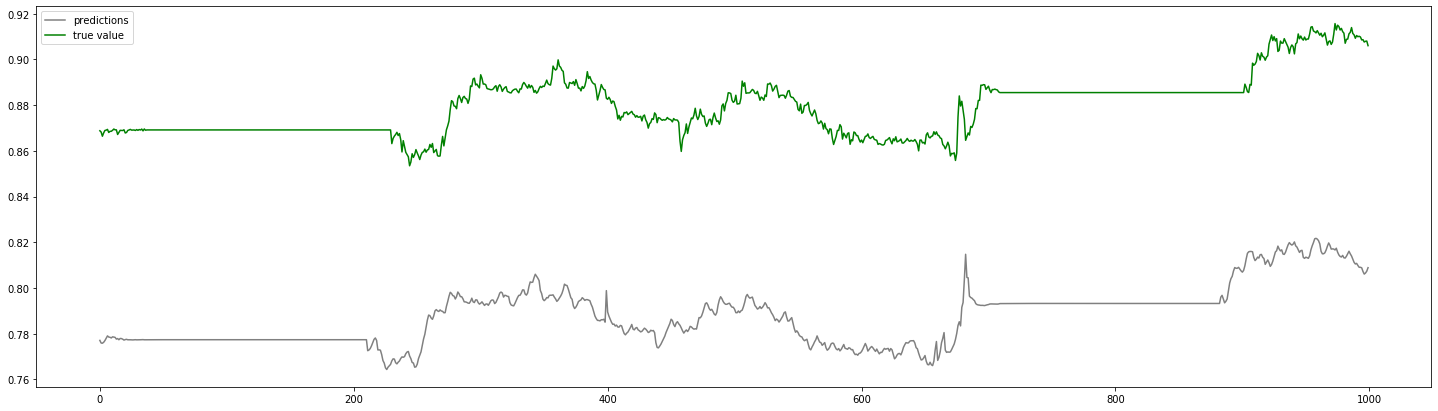

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(predictions[0:1000], label='predictions', color='gray' )
plt.plot(dataset_scaled['close'][0:1000].values, label='true value', color='green')
plt.legend()
plt.show()

In [ ]:
std = np.std(y_targets[0:20], dtype=np.float64)
mean = np.mean(np.abs(predictions[1:21] - y_targets[0:20]))

In [ ]:
std * 2, mean

(0.0008328847634466357, 0.0031687366676940608)

In [ ]:
predictions[21][0], y_targets[20]

(0.86641526, 0.8691329429245696)

In [ ]:
for i in range(20):
  if predictions[i +1 + 20] +mean - y_targets[i+20] < 0 and np.abs(predictions[i +1 + 20] - y_targets[i+20]) + mean > 2 * std:
    print('true I am selling: ', predictions[i +1 + 20] - y_targets[i+20])
  elif predictions[i +1 + 20] +mean - y_targets[i+20] > 0 and np.abs(predictions[i +1 + 20] - y_targets[i+20])+ mean > 2 * std:
    print('true i am buying, ', predictions[i +1 + 20] - y_targets[i+20])
  else:
    print('just waiting...')

true i am buying,  [-0.00271767]
true i am buying,  [-0.00315505]
true I am selling:  [-0.00317341]
true I am selling:  [-0.00320226]
true I am selling:  [-0.00321215]
true I am selling:  [-0.0032106]
true I am selling:  [-0.0032708]
true I am selling:  [-0.0033353]
true I am selling:  [-0.00341433]
true I am selling:  [-0.00337452]
true I am selling:  [-0.00332302]
true I am selling:  [-0.00324398]
true I am selling:  [-0.00325161]
true I am selling:  [-0.00326496]
true I am selling:  [-0.00331789]
true I am selling:  [-0.00327438]
true I am selling:  [-0.00322551]
true I am selling:  [-0.00322145]
true I am selling:  [-0.00322682]
true I am selling:  [-0.00323123]


In [ ]:
reward = 0
ratio = 0.8
bet = 1
cash = 10000
cash_variation = []
win = 0
lose = 0
std = np.std(y_targets, dtype=np.float64)
for i in range(len(predictions) - 1):
  if predictions[i+1] > y_targets[i]:
    # call
    cash -= 1

    # check win or lose
    if y_targets[i + 1] > y_targets[i]:
      cash += 1.8
      win += 1
    else:
      cash = cash
      lose += 1
      pass
  
  elif predictions[i+1] < y_targets[i]:
    # put
    cash -= bet

    # check win or lose
    if y_targets[i + 1] < y_targets[i]:
      cash += 1.8
      win += 1
    else:
      cash = cash
      lose += 1
      pass
  print('===========================')
  print('the cash: ', cash)
  cash_variation.append(cash)
 

Streaming output truncated to the last 5000 lines.
the cash:  6831.199999999002
the cash:  6830.199999999002
the cash:  6829.199999999002
the cash:  6828.199999999002
the cash:  6828.999999999002
the cash:  6829.7999999990025
the cash:  6828.7999999990025
the cash:  6829.599999999003
the cash:  6830.399999999003
the cash:  6831.199999999003
the cash:  6831.999999999003
the cash:  6832.799999999003
the cash:  6831.799999999003
the cash:  6830.799999999003
the cash:  6831.599999999004
the cash:  6832.399999999004
the cash:  6831.399999999004
the cash:  6830.399999999004
the cash:  6831.199999999004
the cash:  6831.999999999004
the cash:  6830.999999999004
the cash:  6829.999999999004
the cash:  6830.799999999004
the cash:  6831.5999999990045
the cash:  6830.5999999990045
the cash:  6831.399999999005
the cash:  6832.199999999005
the cash:  6831.199999999005
the cash:  6830.199999999005
the cash:  6829.199999999005
the cash:  6828.199999999005
the cash:  6827.199999999005
the cash:  6826.1

KeyboardInterrupt: ignored

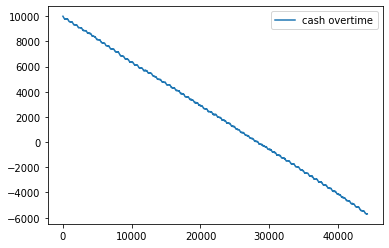

In [ ]:
plt.plot(cash_variation, label='cash overtime')
plt.legend()
plt.show()

In [ ]:
ds_holder['Close'][19:24].values, target_scaled_back[0:5]

(array([1.43236, 1.43268, 1.43277, 1.43268, 1.43303]),
 [1.43274, 1.43284, 1.43325, 1.43334, 1.43346])

In [ ]:
y_targets[0]

0.8678000174809894

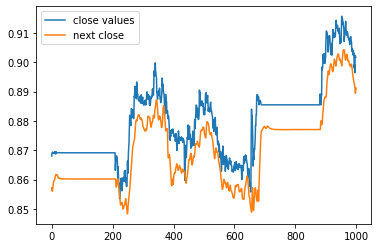

In [ ]:
plt.plot(y_targets[1:1000], label='close values')
plt.plot(predictions[0:1000], label='next close')
plt.legend()
plt.show()

## Connect iqoptions api

In [ ]:
!pip install -U git+git://github.com/Lu-Yi-Hsun/iqoptionapi.git

In [ ]:
import logging
logging.basicConfig(level=logging.CRITICAL,format='%(asctime)s %(message)s')

DEBUG:iqoptionapi.ws.client:{"name":"timeSync","msg":1582309146905}


In [ ]:
logger = logging.getLogger('my-logger')
logger.propagate = False

In [ ]:
import time
import pandas as pd
from tensorflow.keras.models import load_model
from iqoptionapi.stable_api import IQ_Option

model = load_model('/content/drive/My Drive/tradingBot/models/BidirectionalLSTM-11-Loss-0.000630-Val_Loss-0.000135.model')
I_want_money=IQ_Option("hesllerh@gmail.com","Zinho1508!")
I_want_money.change_balance('PRACTICE')

In [ ]:
goal="USDJPY"
print("get candles")
candles = I_want_money.get_candles(goal,900,100,time.time())

get candles


In [ ]:
candles = pd.DataFrame(candles)
candles.tail()

Format dataset

In [ ]:
def scale_back(dataset, prediction):
  for value in prediction:
    x_std = (value - 0) / ( 1 - 0)
    prediction_scaled_back = x_std * ((dataset['Close'].max() - dataset['Close'].min())) + dataset['Close'].min()

  return prediction_scaled_back

In [ ]:
candles.rename(columns={'open': 'Open', 'close': 'Close', 'min': 'Low', 'max': 'High', 'volume': 'Volume', 'from': 'Time'}, inplace=True)
candles.drop(columns=['at', 'to', 'id'], inplace=True)
#candles.set_index('Time', inplace=True)
candles = candles[['Time','Open', 'High', 'Low', 'Close', 'Volume']]
candles.head()

,Time,Open,High,Low,Close,Volume
0,1582219800,111.8445,111.9575,111.8385,111.9235,2544
1,1582220700,111.9230,112.0380,111.9200,112.0245,2622
2,1582221600,112.0240,112.0965,111.9935,112.0685,2525
3,1582222500,112.0685,112.0805,112.0230,112.0370,2472
4,1582223400,112.0375,112.0760,112.0125,112.0370,2395


In [ ]:
# Obtaining the array of values
# remove ds holder here
dataset, ds_holder = formatting_dataset(candles, training=False) # return scaled dataset


DEBUG:iqoptionapi.ws.client:{"name":"timeSync","msg":1582307703895}


In [ ]:
predictions = model.predict(np.reshape(dataset.tail(20).values, (1, 20, 19)))
predictions

DEBUG:iqoptionapi.ws.client:{"name":"timeSync","msg":1582307707046}
DEBUG:iqoptionapi.ws.client:{"name":"timeSync","msg":1582307707210}


array([[0.34084255]], dtype=float32)

DEBUG:iqoptionapi.ws.client:{"name":"timeSync","msg":1582307707509}


### Main Loop

In [ ]:
ACTIVES="USDJPY"
duration=15
amount=1
actions=['put', 'call']
notdone = True

while True:
  timestamp = I_want_money.get_server_timestamp()
  if timestamp % 900 < 5:
    #time.sleep(5)
    print('')
    print('baixando velas -----')
    candles = I_want_money.get_candles(ACTIVES,900,20,time.time())
    candles = pd.DataFrame(candles)
    candles.rename(columns={'open': 'Open', 'close': 'Close', 'min': 'Low', 'max': 'High', 'volume': 'Volume', 'from': 'Time'}, inplace=True)
    candles.drop(columns=['at', 'to', 'id'], inplace=True)
    #candles.set_index('Time', inplace=True)
    candles = candles[['Time','Open', 'High', 'Low', 'Close', 'Volume']]

    # Obtaining the array of values
    # remove ds holder here
    dataset, ds_holder = formatting_dataset(candles, training=False) # return scaled datase

    # make the prediction
    predictions = model.predict(np.reshape(dataset.tail(20).values, (1, 20, 19)))

    # scaling back
    pred_scaled = scale_back(ds_holder.tail(20), predictions)
    diff = np.abs(pred_scaled - ds_holder['Close'].tail(1).values)
    print('valor anterior: ', ds_holder['Close'].tail(1).values)
    print('valor previsto: ', pred_scaled)
    print('diferença abs ', diff)

    # choosing the action:
    if pred_scaled < ds_holder['Close'].tail(1).values and diff > 0.05:
      print('')
      print(' ------- abrindo ordem de venda ---------')
      I_want_money.buy_digital_spot(ACTIVES,amount,actions[0],15)
      print('ordem aberta com sucesso')
      t_left = 900 - (timestamp % 900)
      print('Faltam, ', t_left, 'segundos para a proxima tentativa...')
      print('vou dormir um pouco')
      time.sleep(t_left)

    elif pred_scaled > ds_holder['Close'].tail(1).values and diff > 0.05:
      print('')
      print(' ------- abrindo ordem de compra ---------')
      I_want_money.buy_digital_spot(ACTIVES,amount,actions[1],15)
      print('ordem aberta com sucesso')
      t_left = 900 - (timestamp % 900)
      print('Faltam, ', t_left, 'segundos para a proxima tentativa...')
      print('vou dormir um pouco')
      time.sleep(t_left)
    else:
      print('valores nao se encaixam nos padroes necessarios')
      t_left = 900 - (timestamp % 900)
      print('Faltam, ', t_left, 'segundos para a proxima tentativa...')
      print('vou dormir um pouco')
      time.sleep(t_left)
    
  else:
    print('não é hora de comprar ainda, descanse um pouco')
    t_left = 900 - (timestamp % 900)
    print('Faltam, ', t_left, 'segundos para a proxima tentativa...')
    print('vou dormir um pouco')
    time.sleep(t_left)




### Checklist What to do



*   Criar environment
*   Trazer indicador de sentimento
*   Trazer indicador de Strong Buy Strong Sell

